In [1]:
import matplotlib.pyplot as plt

In [2]:
beacon_locations = {
    3: (62, 0),
    2: (173, 0),
    4: (212, 93),
    5: (309, 173),
    8: (309, 303),
    9: (165, 341),
    6: (45, 110),
    1: (18, 224),
    7: (0, 307)
}

In [3]:
landmark_initial_location = (23, 15)

In [4]:
def add_landmark(dx, dy, steps):
    total_steps, (x, y) = landmark_locations[-1]
    new_landmark = total_steps + steps, (x + dx, y + dy)
    landmark_locations.append(new_landmark)

In [5]:
landmark_locations = [(0, landmark_initial_location)]
add_landmark(96, 0, 4)
add_landmark(0, 66, 3)
add_landmark(55, 0, 2)
add_landmark(0, 175, 9)
add_landmark(-36, 36, 3)
add_landmark(-80, 0, 4)
add_landmark(0, -54, 3)
add_landmark(36, -63, 4)
add_landmark(82, 0, 4)
add_landmark(-109, 0, 5)
add_landmark(0, -90, 4)
add_landmark(52, -4, 2)
add_landmark(0, -66, 3)
add_landmark(146, 0, 7)
add_landmark(0, 324, 16)

In [6]:
# interpolate
walk_locations = [landmark_locations[0]]
for loc1, loc2 in zip(landmark_locations, landmark_locations[1:]):
    step1, (x1, y1) = loc1
    step2, (x2, y2) = loc2
    ds = step2 - step1
    dx, dy = x2 - x1, y2 - y1
    for s in range(1, ds + 1):
        walk_coordinate = (x1 + 1. * s / ds * dx, y1 + 1. * s / ds * dy)
        walk_location = (step1 + s, walk_coordinate)
        walk_locations.append(walk_location)

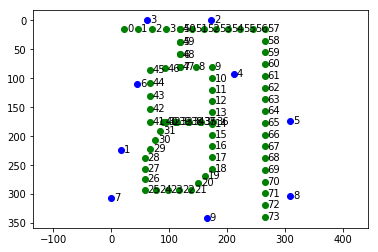

In [8]:
margin = 50
xs, ys = zip(*beacon_locations.values())
axis_limits = [min(xs) - margin, max(xs) + margin, min(ys) - margin, max(ys) + margin]
fig, ax = plt.subplots()

# assume all beacons in beacon_distances are also in beacon_locations
for minor in beacon_locations:
    x, y = beacon_locations[minor][:2]
    ax.plot(x, y, 'bo')
    ax.annotate(minor, (x, y), xytext=(x + 5, y + 5))

for step, (x, y) in walk_locations:
    ax.plot(x, y, 'go')
    ax.annotate(step, (x, y), xytext=(x + 5, y + 5))

plt.axis(axis_limits)
ax.axis('equal')
plt.gca().invert_yaxis()
plt.show()